In [1]:
from keras import __version__
import numpy as np
from keras.models import model_from_json, Model, Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from keras import optimizers
from sklearn.model_selection import train_test_split
import keras
from tempfile import TemporaryFile
import csv
from sklearn.neighbors import KDTree, NearestNeighbors
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_model(weights_path, json_path):
    json_file = open(json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights(weights_path)
    print("Loaded model from disk")
    return loaded_model

def get_clothing_vector_model(weights_path, json_path):
    loaded_model = load_model(weights_path, json_path)
    loaded_model.layers.pop() # Get rid of the classification layer
    last = loaded_model.layers[-1].output
    model = Model(loaded_model.input, last)
    return model

def image_preprocess(img_path):
    image = load_img(img_path, target_size=(299, 299))
    image = img_to_array(image)

    # our input image is now represented as a NumPy array of shape
    # (inputShape[0], inputShape[1], 3) however we need to expand the
    # dimension by making the shape (1, inputShape[0], inputShape[1], 3)
    # so we can pass it through thenetwork
    image = np.expand_dims(image, axis=0)

    # pre-process the image using the appropriate function based on the
    # model that has been loaded (i.e., mean subtraction, scaling, etc.)
    image = preprocess_input(image)
    return image

def get_classier_prediction(clothing_classifier, img_path):
    clothes_labels = ['dresses', 'handbags', 'hats', 'jackets', 'jeans', 
                      'jewelry', 'shorts', 'skirts', 'sunglasses', 'sweaters', 
                      'sweatshirts', 'womens-outerwear', 'womens-pants', 'womens-shoes', 'womens-tops']
    img = image_preprocess(img_path)
    preds = clothing_classifier.predict(img)[0]
    preds_labels = list(zip(clothes_labels, preds))
    preds_labels.sort(key=lambda p: p[1], reverse=True)
    return preds_labels

In [3]:
clothing_classifier_weights_path = 'model_files/inceptionv3_clothing_expanded_classifier.h5'
clothing_classifier_json_path = 'model_files/incep_filter_clothing_expanded_classifier.json'
clothing_classifier = load_model(clothing_classifier_weights_path, clothing_classifier_json_path)
clothing_classifier.summary()

Loaded model from disk
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_234 (Conv2D)              (None, None, None, 32 864         input_4[0][0]                    
____________________________________________________________________________________________________
batch_normalization_233 (BatchNo (None, None, None, 32 96          conv2d_234[0][0]                 
____________________________________________________________________________________________________
activation_233 (Activation)      (None, None, None, 32 0           batch_normalization_233[0][0]    
____________________________________________________________________

In [4]:
jeans_img_path = 'data-all/validation/jeans/482888849.jpg'
dress_img_path = 'data-all/validation/dresses/535993294.jpg'
jackets_img_path = 'data-all/validation/jackets/614521319.jpg'
jackets_img_path2 = 'data-all/validation/jackets/614763686.jpg'
sunglasses_img_path = 'data-all/validation/sunglasses/655241570.jpg'
dog_img_path = 'data-pets/train/dogs/dog.0.jpg'
get_classier_prediction(clothing_classifier, jeans_img_path)

[('jeans', 0.9994086),
 ('womens-pants', 0.00057120068),
 ('skirts', 9.8398305e-06),
 ('shorts', 5.155051e-06),
 ('womens-shoes', 1.597728e-06),
 ('dresses', 1.3391341e-06),
 ('sunglasses', 1.1239276e-06),
 ('handbags', 4.7019503e-07),
 ('womens-tops', 2.4409596e-07),
 ('jackets', 1.825323e-07),
 ('sweaters', 1.2994336e-07),
 ('womens-outerwear', 1.1318394e-07),
 ('sweatshirts', 6.9145734e-08),
 ('jewelry', 2.7152955e-08),
 ('hats', 1.3843319e-08)]

In [5]:
classifier_vector_model = get_clothing_vector_model(clothing_classifier_weights_path, clothing_classifier_json_path)
img_jacket = image_preprocess(jackets_img_path)
img_jacket2 = image_preprocess(jackets_img_path2)
img_jeans = image_preprocess(jeans_img_path)
img_dress = image_preprocess(dress_img_path)
img_dog = image_preprocess(dog_img_path)

jacket_feat = classifier_vector_model.predict(img_jacket)
jacket_feat2 = classifier_vector_model.predict(img_jacket2)
jeans_feat = classifier_vector_model.predict(img_jeans)
dress_feat = classifier_vector_model.predict(img_dress)
dog_feat = classifier_vector_model.predict(img_dog)

jacket_feat

Loaded model from disk


array([[ 0.48110151,  1.57449138,  0.03476693, ...,  1.22023451,
         0.35871747,  0.71462518]], dtype=float32)

In [6]:
# compare cosine similarities
print('2 jackets: ', cosine_similarity(jacket_feat, jacket_feat2))
print('jeans and dress: ', cosine_similarity(jeans_feat, dress_feat))
print('jeans and dog: ', cosine_similarity(jeans_feat, dog_feat))

2 jackets:  [[ 0.97938681]]
jeans and dress:  [[ 0.97675431]]
jeans and dog:  [[ 0.98362172]]


In [7]:
jacket_feat.shape # (1, 1024)

(1, 1024)

## Skipgrams Model

In [8]:
def save_product_features(model, product_file, img_dir, output_file):
    products = []
    print('Reading file ', product_file)
    with open(product_file, 'r') as f:
        for i, line in enumerate(f.readlines()[:]):
            if i % 50 == 0:
                print('Processing product ', i)
            try:
                l = line.split('\t')
                product_id = l[0]
                product_img_path = img_dir + product_id + '.jpg' 
                product_img = image_preprocess(product_img_path)
                product_feat = model.predict(product_img)
    
                products.append([product_id] + product_feat[0].tolist())
            except Exception as e:
                print(e)
                
    print('Saving products to ', output_file)
    with open(output_file, 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        for p in products:
            writer.writerow(p)
            f.flush()
    return products

def make_product_X_y(product_to_features, product1_id, product2_id, product3_id):
    product1_feat = product_to_features[product1_id]
    product2_feat = product_to_features[product2_id]
    product3_feat = product_to_features[product3_id]

    merged_feat = np.concatenate((product1_feat, product2_feat), axis=1)
    return merged_feat, product3_feat
    
    
def make_product_permutation_generator(outfit_permutations_file, product_to_features, batch_size):
    while True:
        with open(outfit_permutations_file, 'r') as f:
            curr_batch_X = []
            curr_batch_y = []
            for line in f:
                if len(curr_batch_X) == batch_size:
                    curr_batch_X = []
                    curr_batch_y = []
                    
                l = line.split()
                product1_id = l[2]
                product2_id = l[5]
                product3_id = l[8]
                merged_feat, y_feat = make_product_X_y(product_to_features, product1_id, product2_id, 
                                                       product3_id)
                curr_batch_X.append(merged_feat)
                curr_batch_y.append(y_feat)
                if len(curr_batch_X) == batch_size:
                    yield (np.array(curr_batch_X), np.array(curr_batch_y))


def get_product_to_features(product_feats_file):
    product_to_feats = {}
    number_features_to_keep = 300
    rf_feature_import_file = 'rf_feat_import.dat'
    all_feat_importances = np.load(rf_feature_import_file)
    top_features = sorted(list(zip(range(0, 1024), all_feat_importances)), key=lambda tup: tup[1], reverse=True)
    bottom_feature_indexes = [f[0] for f in top_features[number_features_to_keep:]]
    with open(product_feats_file, 'r') as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter='\t')
        for row in tsvreader:
            product_id = row[0]
            feats_stored = [float(n) for n in row[1:]]
            feats_reduced = np.delete(feats_stored, bottom_feature_indexes)
            feats = np.array([feats_reduced])
            product_to_feats[product_id] = feats
    return product_to_feats


def save_product_features(product_file, product_to_features):
    """for TSNE"""
    output_features_file = 'product_features_tsne.tsv'
    output_labels_file = 'product_names_tsne.tsv'
    f_features = open(output_features_file, 'w')
    writer_features = csv.writer(f_features, delimiter='\t')
    
    f_labels = open(output_labels_file, 'w')
    writer_labels = csv.writer(f_labels, delimiter='\t')
    print('Reading file ', product_file)
    with open(product_file, 'r') as f:
        for i, line in enumerate(f.readlines()[:]):
            if i % 1000 == 0:
                print('Processing product ', i)
            try:
                l = line.split('\t')
                product_id = l[0]
                features = product_to_features[product_id]
                writer_features.writerow(features[0])
                f_features.flush()
            
                product_name = l[3]
                product_category = l[2]
                writer_labels.writerow([product_name.strip(), product_category])
                f_labels.flush()
            
            except Exception as e:
                print(e)
    

In [9]:
product_feats_file = 'data-outfits/outfit_product_features_small.tsv'
outfit_permutations_file = 'data-outfits/outfit_permutations_small.tsv'
prods_to_feats = get_product_to_features(product_feats_file)

In [10]:
len(prods_to_feats['641336745'][0])

300

In [11]:
def display_images(image_paths):
    image_count = len(image_paths)
    fig, ax = plt.subplots(1, image_count, figsize=(image_count*5, 4))
    
    for i, image_file in enumerate(image_paths):
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
        ax[i].imshow(image, interpolation='nearest')
        ax[i].axis("off")
    plt.show()

def display_product_images(product_ids):
    image_files = ['data-outfits/images_small/' + product_id + '.jpg' for product_id in product_ids]
    display_images(image_files)

    
def get_prod_feat_list():
    index_to_prod = {}
    prod_features = []
    for i, prod_feat in enumerate(prods_to_feats.items()):
        prod_id, feat = prod_feat
        index_to_prod[i] = prod_id
        prod_features.append(feat[0])
    return index_to_prod, np.array(prod_features)

index_to_prod, prod_features = get_prod_feat_list()
print('Making Nearest Neighbors ...')
#neighbors_model = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute')
neighbors_model = NearestNeighbors(n_neighbors=20, metric='l2', algorithm='auto')
neighbors_model.fit(prod_features)

Making Nearest Neighbors ...


NearestNeighbors(algorithm='auto', leaf_size=30, metric='l2',
         metric_params=None, n_jobs=1, n_neighbors=20, p=2, radius=1.0)

In [12]:
neighbors_model.kneighbors(prod_features[:3], 5, return_distance=True)

(array([[ 0.        ,  2.74506652,  2.98413448,  2.98872838,  3.04837431],
        [ 0.        ,  2.85073999,  2.92198254,  2.97656326,  3.00930863],
        [ 0.        ,  2.24719252,  3.07435192,  3.24697655,  3.41816637]]),
 array([[    0, 18511, 12938, 10611,  8989],
        [    1,  5352,  5965, 13025,  6423],
        [    2,  4417, 14799,  5745, 13840]]))

In [27]:
def get_closest_products(input_features, model, index_to_prod_mapping, count=15):
    """Only allow one product at a time"""
    product_distances, product_indexes = model.kneighbors(input_features, count, return_distance=True)
    closest_product_ids = [index_to_prod_mapping[index] for index in product_indexes[0]]
    return closest_product_ids, product_distances[0]

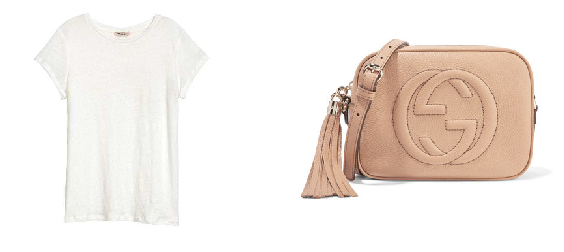

In [14]:
white_shirt_id = '633073622'
pink_bag_id = '645667402'
display_product_images([white_shirt_id, pink_bag_id])

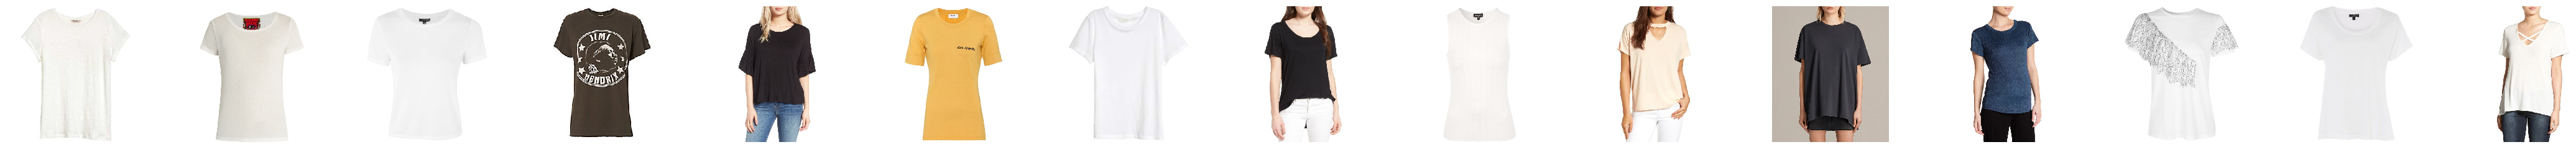

array([ 0.        ,  1.84982539,  2.04049565,  2.08452262,  2.10439025,
        2.14468707,  2.20593361,  2.22383622,  2.25416689,  2.25660301,
        2.28305012,  2.28722987,  2.28906817,  2.29097514,  2.30375447])

In [29]:
white_shirt_vector = prods_to_feats[white_shirt_id]
closest_white_shirt_ids, closest_white_shirt_distances = get_closest_products(white_shirt_vector, neighbors_model, index_to_prod, count=1000)
display_product_images(closest_white_shirt_ids[:15])
closest_white_shirt_distances[:15]

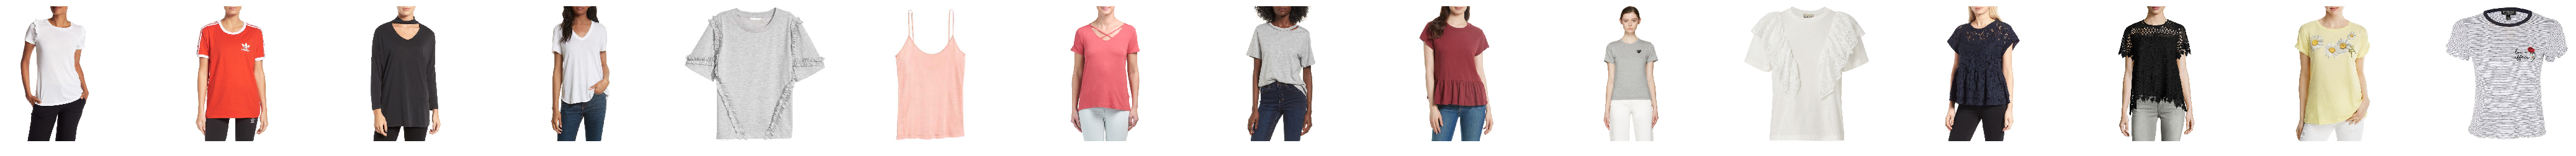

array([ 2.71604871,  2.71595806,  2.70942441,  2.69734553,  2.69640646,
        2.68799047,  2.68784515,  2.68602608,  2.68105811,  2.67658279,
        2.67619238,  2.67313714,  2.66692101,  2.66565345,  2.66483547])

In [37]:
# furthest white shirts
furthest_white_shirt_ids = closest_white_shirt_ids[::-1]
furthest_white_shirt_distances = closest_white_shirt_distances[::-1]
display_product_images(furthest_white_shirt_ids[900:915])
furthest_white_shirt_distances[900:915]

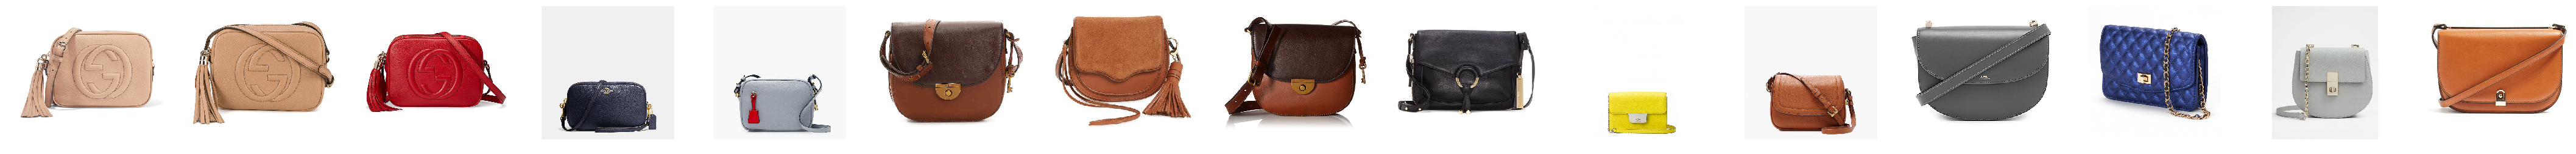

array([ 0.        ,  2.97052488,  3.50921206,  4.07307682,  4.17126653,
        4.2536945 ,  4.39010243,  4.3999093 ,  4.50209666,  4.57228874,
        4.65353393,  4.72763147,  4.74731845,  4.75303711,  4.78076065])

In [39]:
pink_bag_vector = prods_to_feats[pink_bag_id]
closest_pink_bag_ids, closest_pink_bag_dists= get_closest_products(pink_bag_vector, neighbors_model, index_to_prod)
display_product_images(closest_pink_bag_ids)
closest_pink_bag_dists

error: /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.cpp:10606: error: (-215) scn == 3 || scn == 4 in function cvtColor


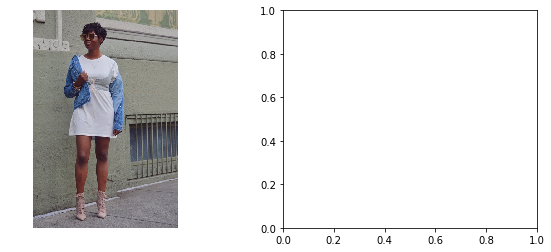

In [17]:
collection_ids = ['42911776', ' ']
collection_paths = ['data-outfits/images_collections/' + cid + '.jpg' for cid in collection_ids]
display_images(collection_paths)

In [ ]:
get_classier_prediction(clothing_classifier, collection_paths[1])